# Fitting RooFit-generated likelihoods

In this tutorial, we show how to create a negative log-likelihood function with the [RooFit framework](https://root.cern/manual/roofit/) and minimize it with iminuit. 

RooFit is a powerful fitting framework developed by CERN's ROOT team.
RooFit is very powerful and sophisticated, but there are a few reasons to use iminuit instead:

- RooFit documention is extensive, but lacking in important places
- RooFit interfaces are not Pythonic, they mimic the C++ interfaces (which are also dated)
- Errors are difficult to understand and debug since RooFit is internally executing C++ code
- You may experience segmentation faults when using RooFit from Python due to bugs in the ROOT Python layer (problems with handling life-times of dynamic C++ objects in Python correctly)

For these reasons, you may consider to transition to iminuit and its cost functions for your project. As a first step, you want to convince yourself that iminuit gives you the same fitting result as you get from RooFit. 

In [1]:
# ROOT is best installed via a conda virtual environment from conda-forge
import ROOT

Welcome to JupyROOT 6.26/10


In [2]:
# fix PRNG seed for RooFit random number generation
ROOT.RooRandom.randomGenerator().SetSeed(1)

We generate a Gaussian with mean 1 and width 3 and draw 10000 data points from it. 

In [3]:
x = ROOT.RooRealVar("x", "x", -10, 10)
mean = ROOT.RooRealVar("mean", "mean of gaussian", 1, -10, 10)
sigma = ROOT.RooRealVar("sigma", "width of gaussian", 3, 0.1, 10)

gauss = ROOT.RooGaussian("gauss", "gaussian PDF", x, mean, sigma)

data = gauss.generate({x}, 10000)

We now fit this Gaussian. We use the `createNLL` method and a simple wrapper function `evaluate`. Note that this simple wrapping function does not propagate the parameter names of the Gaussian to iminuit. A future version of iminuit will come with a builtin wrapper that will also propagate the names and limits.

In [4]:
from iminuit import Minuit

nll = gauss.createNLL(data)

def evaluate(*args):
    for par, arg in zip(nll.getVariables(), args):
        par.setVal(arg)
    # following RooMinimizerFcn.cxx 
    nll.setHideOffset(False)
    r = nll.getVal()
    nll.setHideOffset(True)
    return r

evaluate.errordef = Minuit.LIKELIHOOD

m = Minuit(evaluate, *[p.getVal() for p in nll.getVariables()])
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.514e+04                  │              Nfcn = 31               │
│ EDM = 2.72e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.003   │   0.030   │            │            │         │         │       │
│ 1 │ x1   │   3.017   │   0.022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 0.000926        0 │
│ x1 │        0 0.000497 │
└────┴───────────────────┘

Let's compare this to fitting directly with the `fitTo` method.

In [5]:
gauss.fitTo(data);

[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 mean         1.00653e+00  2.00000e+00   -1.00000e+01  1.00000e+01
     2 sigma        3.01930e+00  9.90000e-01    1.00000e-01  1.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=25136.7 FROM MIGRAD    STATUS=INITIATE       10 CALLS          11 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ER

The results are in agreement, because the results of a fit cannot depend on the minimizer. Technically, RooFit uses a different minimizer than iminuit by default. Unless you change some options, RooFit uses the original MINUIT Fortran implementation translated to C, while iminuit uses the rewritten Minuit2 C++ library.

Just doing the fitting with iminuit does not offer you a lot of advantages. Eventually, you want to switch completely. The equivalent of this exercise in pure Python is the following.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.998e+04                  │              Nfcn = 29               │
│ EDM = 3e-06 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   0.96    │   0.03    │            │            │         │         │       │
│ 1 │ sigma │   2.985   │   0.022   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 0.000906        0 │
│ sigma │        0 0.000483 │
└───────┴───────────────────┘

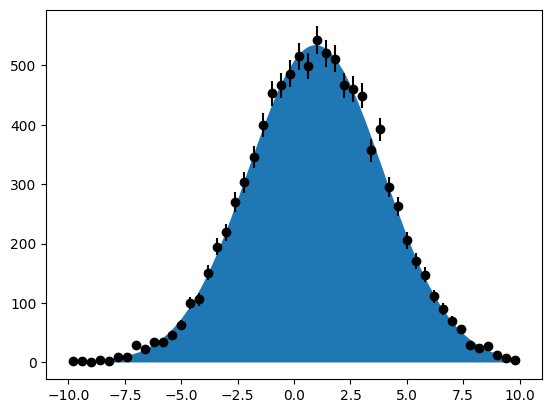

In [6]:
from scipy.stats import truncnorm
from iminuit.cost import UnbinnedNLL
import numpy as np

xrange = (-10., 10.)

rng = np.random.default_rng(1)
x = rng.normal(1, 3, size=10000)
x = x[(xrange[0] < x) & (x < xrange[1])]

def model(x, mu, sigma):
    zrange = np.subtract(xrange, mu) / sigma
    return truncnorm.pdf(x, *zrange, mu, sigma)

# better use numba_stats.truncnorm, which is simpler to use and faster
#
# from numba_stats import truncnorm
#
# def model(x, mu, sigma):
#     return truncnorm.pdf(x, *xrange, mu, sigma)

nll = UnbinnedNLL(x, model)
m = Minuit(nll, 1, 3)
m.migrad()

We do not get the exact same fitted values as before, since the data sample is different from the one generated by RooFit.

To get the exact same result, we need to convert the variable `data` which has the type `RooDataSet` into a numpy array. The ROOT Python layer offers the method `to_numpy` for this purpose.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.027e+04                  │              Nfcn = 31               │
│ EDM = 5.43e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   1.003   │   0.030   │            │            │         │         │       │
│ 1 │ sigma │   3.017   │   0.022   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 0.000926        0 │
│ sigma │        0 0.000497 │
└───────┴───────────────────┘

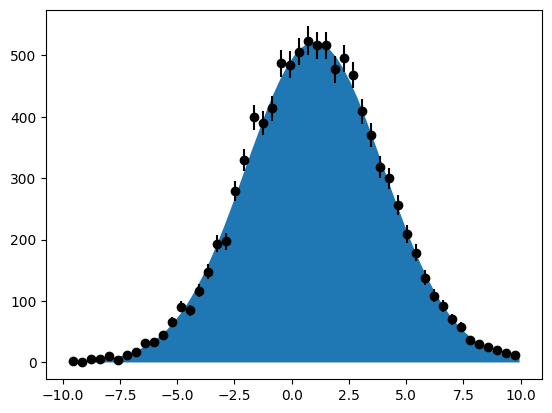

In [7]:
x = data.to_numpy()["x"]

nll = UnbinnedNLL(x, model)
m = Minuit(nll, 1, 3)
m.migrad()